In [1]:
import os
import numpy as np
from phathom import io
from phathom.phenotype import celltype
from phathom import plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
%matplotlib notebook

In [3]:
working_dir = '/media/jswaney/ssd/organoid_phenotyping/20181206_eF9_A34_1/'

# Load cell type labels

In [4]:
centers_path = 'centers.npy'
sox2_path = 'sox2_labels.npy'
tbr1_path = 'tbr1_labels.npy'

centers = np.load(os.path.join(working_dir, centers_path))
sox2_labels = np.load(os.path.join(working_dir, sox2_path))
tbr1_labels = np.load(os.path.join(working_dir, tbr1_path))

assert centers.shape[0] == sox2_labels.shape[0] == tbr1_labels.shape[0]

# Calculate region-oriented features

In [5]:
n_neighbors = 100

distances, indices = celltype.query_neighbors(centers, n_neighbors)

In [6]:
features = celltype.local_densities(distances, 
                                    indices, 
                                    sox2_labels, 
                                    tbr1_labels)

In [7]:
features.shape

(2421822, 2)

In [8]:
%matplotlib inline

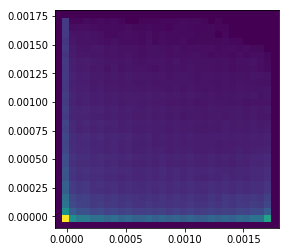

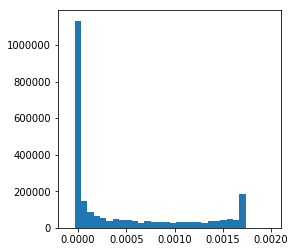

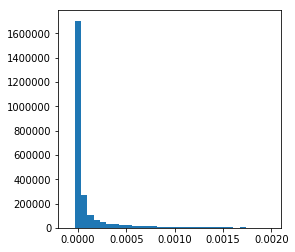

In [71]:
# _range = None
# cmin, cmax = 0, 100000
# plotting.plot_hist_2d(features[:, 0], features[:, 1], 32, _range, cmin, cmax)
# plt.clim([0, 1000000])

plt.figure(figsize=(4, 4))
plt.hist2d(features[:, 0], features[:, 1], bins=32, 
           range=((-0.0001, 0.0018), (-0.0001, 0.0018)), norm=mpl.colors.PowerNorm(0.3))
plt.show()

plt.figure(figsize=(4, 4))
plt.hist(features[:, 0], bins=32, range=(-0.0001, 0.002))
plt.show()

plt.figure(figsize=(4, 4))
plt.hist(features[:, 1], bins=32, range=(-0.0001, 0.002))
plt.show()

In [60]:
idx = np.arange(len(features))
np.random.shuffle(idx)

In [61]:
subset = features[idx[:50000]]

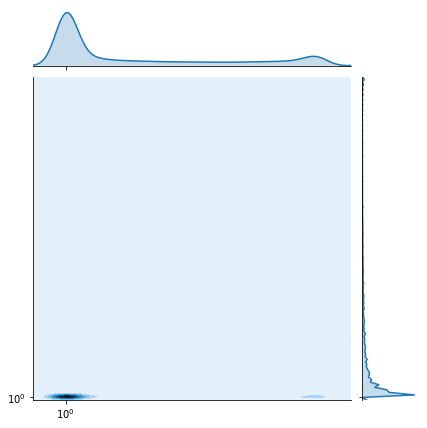

In [62]:
g = sns.jointplot(subset[:, 0]+1, subset[:, 1]+1, 
                  kind="kde", shade=True)
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

# Option 1: Cluster based on cell-type composition

In [9]:
# connectivity = celltype.connectivity(centers, n_neighbors=n_neighbors)

In [10]:
# This is memory intensive and doesn't work on whole organoid
# region_labels = celltype.cluster(features, 
#                                  n_clusters=3,
#                                  connectivity=None)

In [11]:
kmeans = celltype.kmeans(features, n_clusters=3)
region_labels = kmeans.predict(features)

kmeans.cluster_centers_, region_labels

(array([[4.44323510e-05, 8.89965855e-05],
        [1.53761747e-03, 6.39861941e-05],
        [7.35171376e-04, 1.26939737e-04]]),
 array([1, 1, 1, ..., 2, 2, 2], dtype=int32))

# Option 2: Threshold the cell-type composition features

In [124]:
sox2_threshold = 0.0003
tbr1_threshold = 0.00016

sox2_rich = np.where(np.logical_and(features[:, 0] >= sox2_threshold,
                                    features[:, 1] < tbr1_threshold))[0]
tbr1_rich = np.where(features[:, 1] >= tbr1_threshold)[0]
other_rich = np.where(np.logical_and(features[:, 0] < sox2_threshold,
                                     features[:, 1] < tbr1_threshold))[0]

len(sox2_rich), len(tbr1_rich), len(other_rich)

(784178, 343278, 1294366)

In [125]:
region_labels = np.zeros(len(centers), np.uint8)
region_labels[sox2_rich] = 1
region_labels[tbr1_rich] = 2
# other rich is 0 by default

# Visualize the region labels on a projection

In [86]:
syto16_path = 'syto16.zarr/1_1_1'
sox2_path = 'sox2.zarr/1_1_1'
tbr1_path = 'tbr1.zarr/1_1_1'

syto16_arr = io.zarr.open(os.path.join(working_dir, syto16_path))
sox2_arr = io.zarr.open(os.path.join(working_dir, sox2_path))
tbr1_arr = io.zarr.open(os.path.join(working_dir, tbr1_path))

<IPython.core.display.Javascript object>


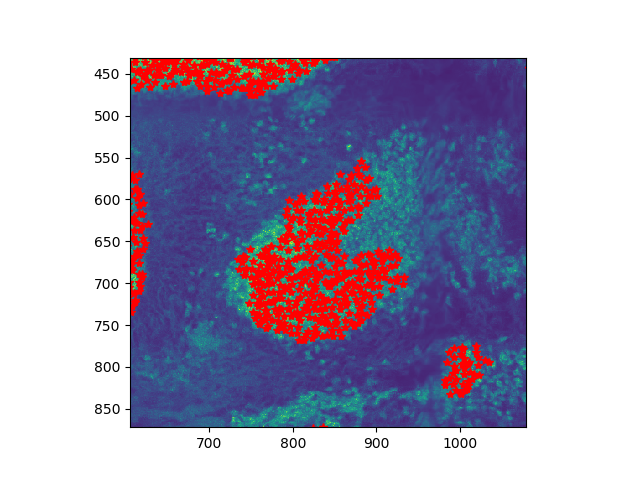

In [127]:
plt.figure()
plotting.zprojection(sox2_arr, centers[sox2_rich], zlim=[200, 208])

<IPython.core.display.Javascript object>


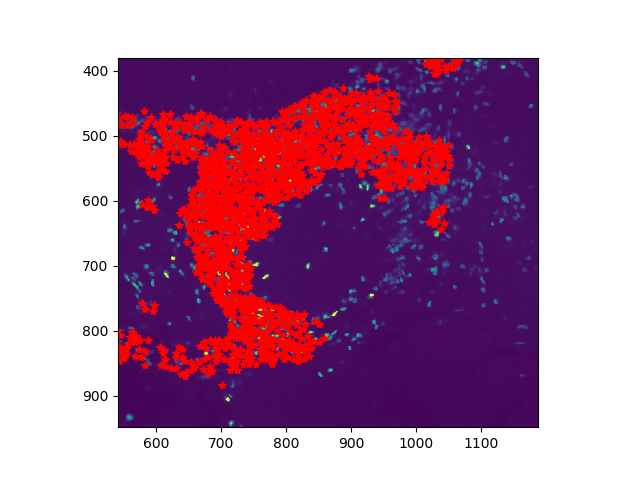

In [128]:
plt.figure()
plotting.zprojection(tbr1_arr, centers[tbr1_rich], zlim=[200, 208])

<IPython.core.display.Javascript object>


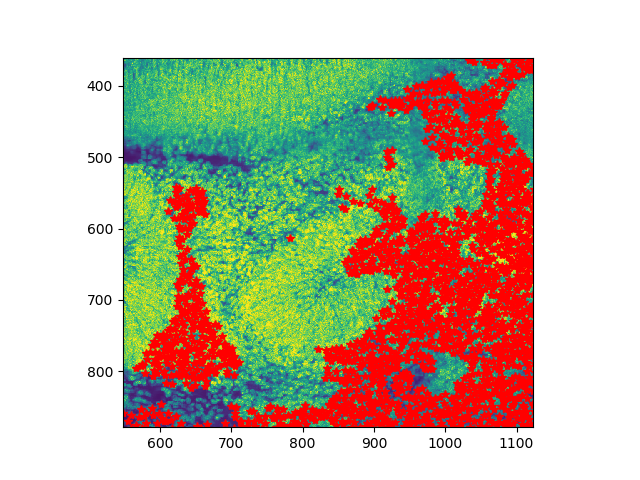

In [129]:
plt.figure()
plotting.zprojection(syto16_arr, centers[other_rich], zlim=[200, 208])

# Convert region labels to segmentation

In [130]:
# This takes about 2 hours
seg = celltype.rasterize_regions(centers, 
                                 region_labels, 
                                 syto16_arr.shape,
                                 syto16_arr.chunks)

100%|██████████| 15466/15466 [1:38:12<00:00,  5.16it/s]  


In [131]:
with seg.txn() as a:
    seg = a[:]
seg.shape, seg.dtype

((650, 2364, 2376), dtype('uint8'))

<IPython.core.display.Javascript object>


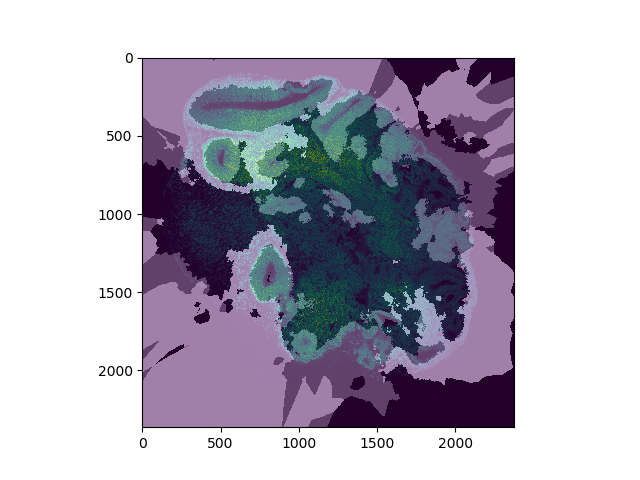

In [132]:
plt.imshow(syto16_arr[200])
plt.imshow(seg[200], alpha=0.5, cmap='gray')
plt.show()

In [ ]:
# TODO: make region rasterization parallelized so that each chunk can
# be processed separately and directly written to disk

In [74]:
import tifffile

In [133]:
tifffile.imsave(os.path.join(working_dir, 'threshold_raster.tif'), seg, compress=1)